# Functions needed to compute u*

In [1]:
import torch
from torch.autograd import Variable
import scipy.optimize

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return torch.reciprocal(torch.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*torch.exp(-1.0/g*X)*torch.reciprocal(torch.exp(-1.0/g*X)+1.)**2

# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = int(*N_lst.size())
    W = torch.zeros(N,N)
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = torch.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*torch.exp(-dist/(r+eps)**2)

    W.fill_diagonal_(0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = int(*N_lst.size())
    W = weight(X,N_lst,r,eps)
    D = torch.diag(torch.sum(W,1))
    L = D - W
    return (1/tau**2*(L + tau**2*torch.eye(N)))**alpha

In [46]:

# -----------Newton's Method----------------------------------

# Newtons method function
def newton(f, x0, tol=1e-05, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    x = Variable(x0, requires_grad = True)
#     for _ in range(maxiter):
#         val = f(x)
#         val.backward()
#         step = (val/x.grad)
#         x.data -= step.data
#         a = torch.linalg.norm(step) 
#         if a < tol:
#             break
# #         if torch.linalg.norm(step) < tol:
# #             break
#         x.grad.data.zero_()
    for it in range(maxiter):
        hess = torch.autograd.functional.hessian(f, x)
        grad = torch.autograd.grad(f(x), x)
        step = torch.linalg.solve(hess, -grad[0])
        x.data += step
        if torch.linalg.norm(step) < tol:
            break
    
    return x.data

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for j,Z_j in enumerate(Z_p):
        u_j = torch.where(N_lst == Z_j)
        S = S - torch.log(cap_psi(y[Z_j]*u[u_j],g))
    return S


# Returns u* using newton's method
def u_ast_NEWT(X, N_lst, y, Z_p, config):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''

    # adjusted for autograd: floats saving parameters
    if not torch.is_tensor(N_lst):
        N_lst = torch.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        final = 0.5*torch.dot(u, torch.matmul(C_inv.float(),u)) + misfit(u, N_lst, y, Z_p, g)
        return final
    x_0 = torch.zeros(*N_lst.size())
    return newton(probit_min, x_0)

# Using gradient descent instead of Newton's method to find uast
def u_ast_GRAD(X, N_lst, g, alpha, tau, eps, rval, y, Z_p, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    # adjusted for autograd: floats saving parameters
    if not torch.is_tensor(N_lst):
        N_lst = torch.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    
    u = torch.zeros(*N_lst.size(), requires_grad = True)
    # Minimizer u for problem defined in [3]-(3)
    maxit = 100
    learning_rate = 1e-3
    tol = 1e-1
    for it in range(maxit):
        final = 0.5*torch.dot(u, torch.matmul(C_inv.float(),u)) + misfit(u, N_lst, y, Z_p, g)
        final.backward(retain_graph=True)
        with torch.no_grad():
            u -= u.grad*learning_rate
            if u.grad.data.norm(2) < tol:
                break
            u.grad.zero_()
    return u.data



# Set up Data

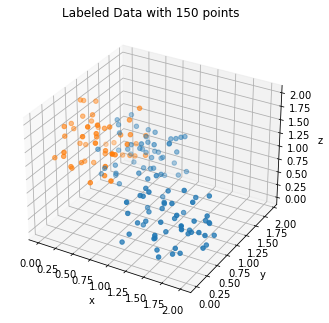

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

xs = torch.rand(N)
ys = torch.rand(N)
zs = torch.rand(N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1.; ys[N_each:2*N_each] += 1.; zs[2*N_each:3*N_each] += 1.
Data = torch.stack((xs, ys, zs), 1)

# true labels
u_dagger = torch.cat((torch.ones(2*N_each), -1*torch.ones(N_each)))
Z_prime = [0,50,100] # Indices of labels
y = torch.sign(u_dagger) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()
